<a href="https://colab.research.google.com/github/bluepsm/GANs-digits/blob/main/generative_adversarial_networks_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks

**Objective:** Generate realistic data (e.g., images, text) from noise.

**Skills:** Deep learning, GAN architecture, training stability techniques, applications in data augmentation and synthetic data generation.

In [1]:
#@title Import library

import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from tqdm.notebook import trange, tqdm
import time
from IPython import display
import imageio
import glob
!pip install tensorflow_docs
import tensorflow_docs.vis.embed as embed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 1.7 MB/s eta 0:00:00


In [2]:
#@title Import dataset

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
#@title Image prepocessing

buffer_size = 60000
batch_size = 256

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

In [4]:
#@title Define Generator

def generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

In [5]:
#@title Define Discriminator

def discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

tf.Tensor([[-0.00248265]], shape=(1, 1), dtype=float32)


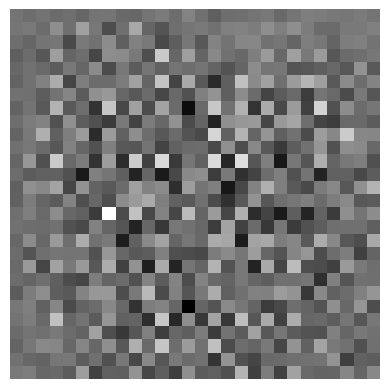

In [6]:
#@title Initializing Generator and Discriminator

generator = generator_model()
discriminator = discriminator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.axis('off')
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

decision = discriminator(generated_image)
print(decision) # output positive values for real images, and negative values for fake images

In [7]:
#@title Define loss optimizers

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss

  return total_loss


def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [8]:
#@title Define checkpoints (Help in case of Colab runtime is interrupted)

checkpoint_dir = '/content/drive/MyDrive/model-ckpt'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [18]:
#@title Define training loop

# The model is already train passed 20 epochs before my Colab is crashed
# So lets restoring the latest checkpoint and train on 30 epochs
epochs = 30
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  noise = tf.random.normal([batch_size, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss


def train(dataset, epochs):
  g_loss_list, d_loss_list = [], []
  g_loss_epoch, d_loss_epoch = [], []

  for epoch in trange(epochs, leave=False):
    start = time.time()

    for image_batch in tqdm(dataset, leave=False):
      g_loss, d_loss = train_step(image_batch)
      g_loss_list.append(g_loss.numpy())
      d_loss_list.append(d_loss.numpy())

    # Convert the tensors to NumPy arrays *outside* the tf.function
    g_loss_epoch.append(sum(g_loss_list) / len(g_loss_list))
    d_loss_epoch.append(sum(d_loss_list) / len(d_loss_list))
    g_loss_list, d_loss_list = [], []

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Save the model every 10 epochs
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

  return g_loss_epoch, d_loss_epoch


def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in trange(predictions.shape[0], leave=False):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  # plt.show()

In [19]:
# prompt: Restore checkpoint of model training

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

  0%|          | 0/16 [00:00<?, ?it/s]

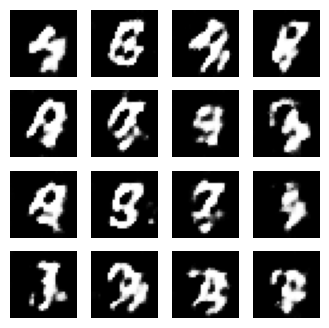

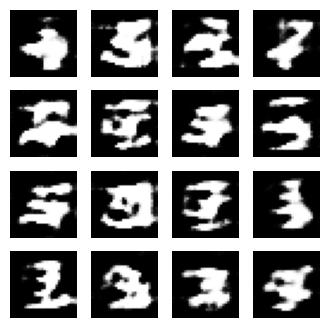

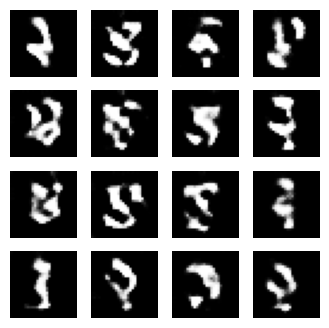

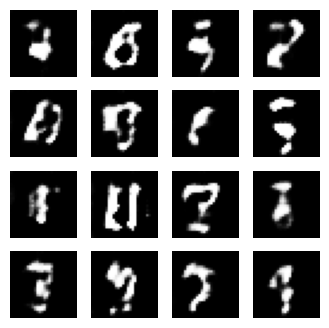

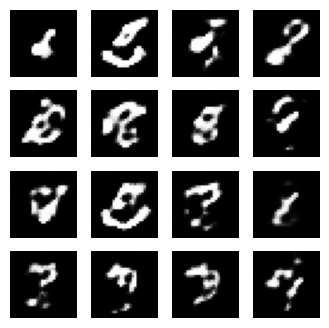

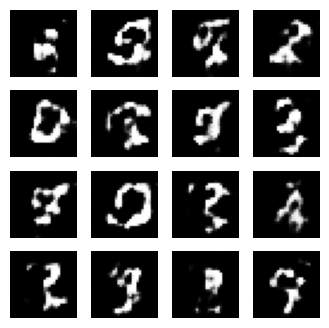

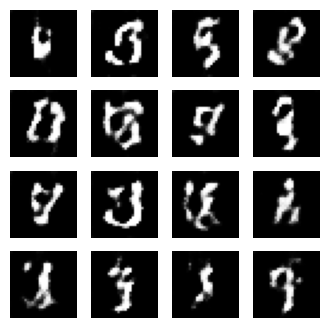

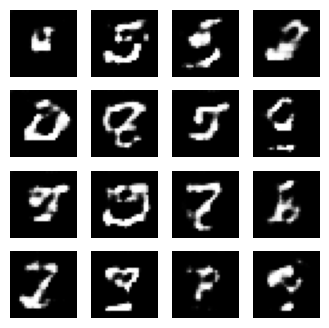

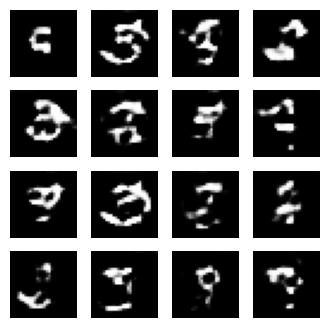

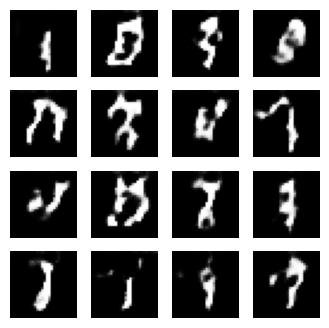

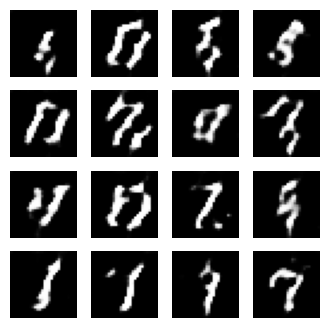

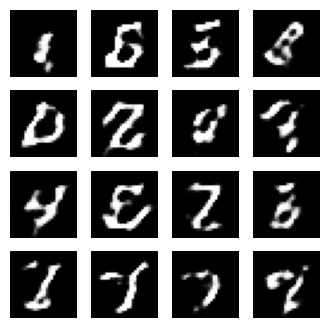

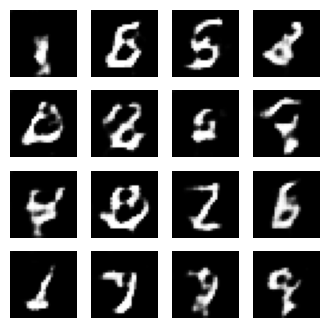

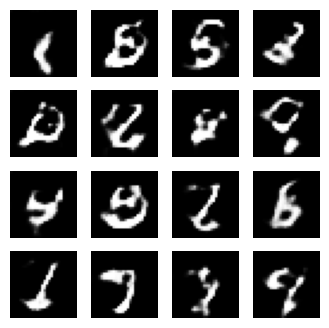

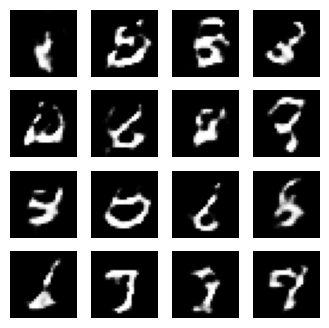

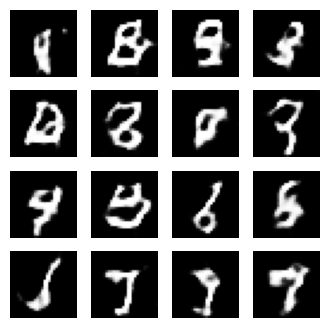

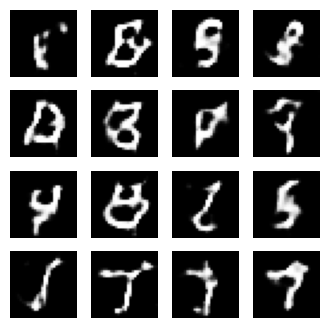

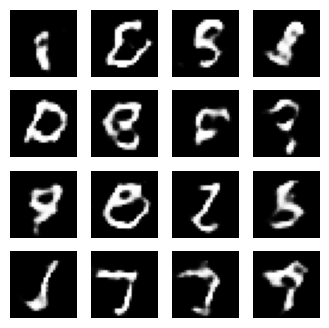

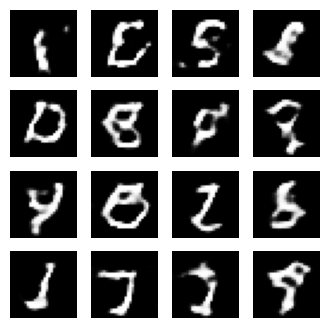

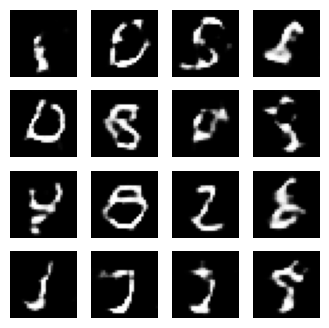

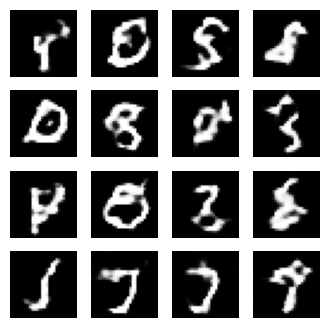

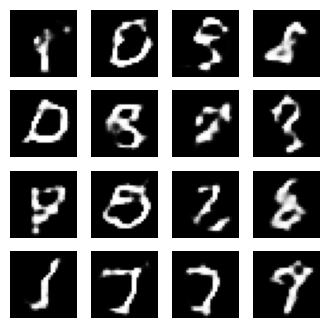

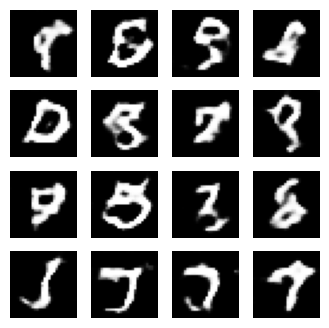

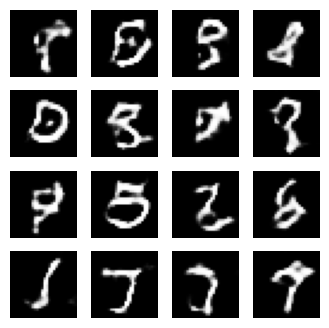

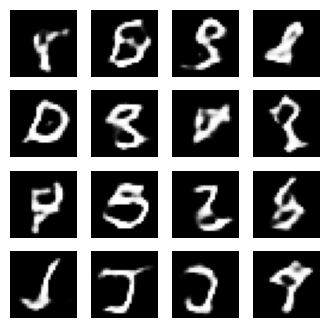

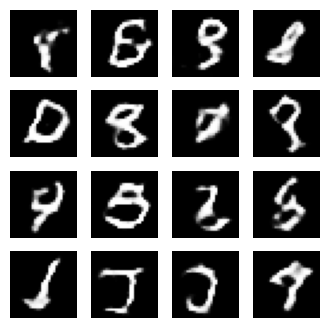

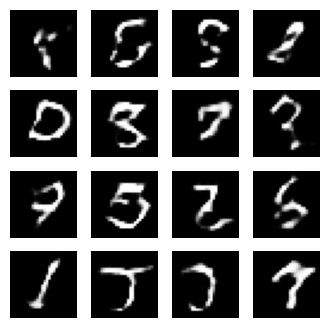

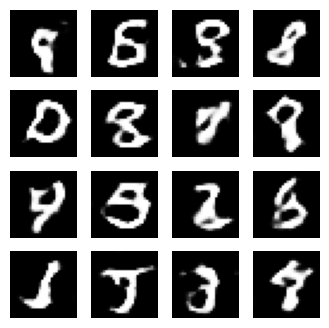

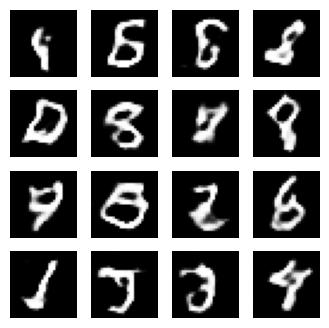

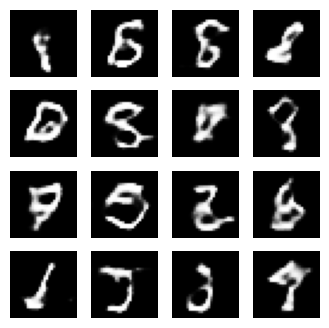

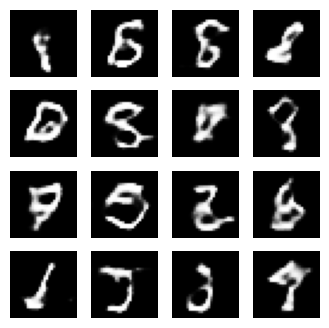

In [20]:
#@title Model training

g_loss_epoch, d_loss_epoch = train(train_dataset, epochs)

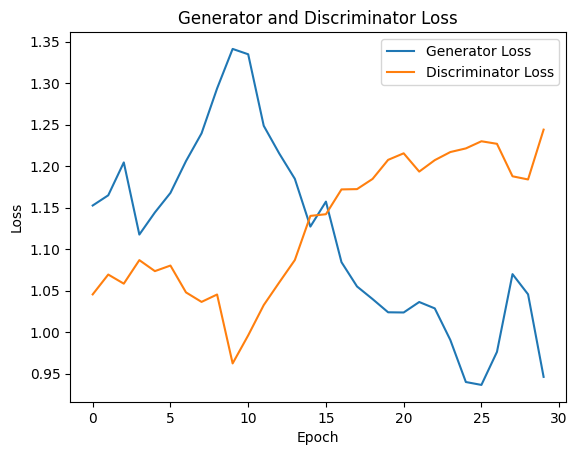

In [21]:
# prompt: Plot the graph of generator and discriminator loss.

# Plot the graph of generator and discriminator loss.
plt.plot(g_loss_epoch, label='Generator Loss')
plt.plot(d_loss_epoch, label='Discriminator Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss')
plt.show()

<ipython-input-22-e1189ee5b456>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-22-e1189ee5b456>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



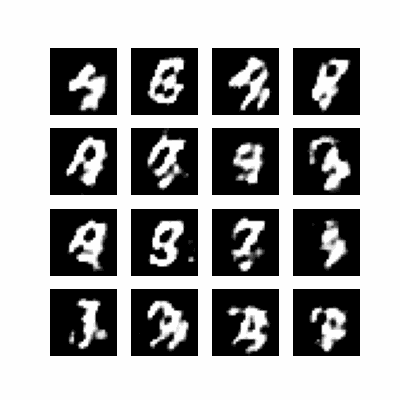

In [22]:
#@title Create GIF of model progress

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)

  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

  image = imageio.imread(filename)
  writer.append_data(image)

embed.embed_file(anim_file)